In [121]:
import json
import os
import xml.etree.ElementTree as ET
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage import exposure, filters, io
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler


In [122]:
base_image_dir = "./Dataset/Images"
base_annot_dir = "./Dataset/Annotation"
gray_output_dir = "./Grayscale_Images"
edge_histograms_dir = "./EdgeHistograms"

dog_classes = [
    "n02088094-Afghan_hound",
    "n02109961-Eskimo_dog",
    "n02113978-Mexican_hairless",
    "n02091467-Norwegian_elkhound",
]


cropped_img_dir = "./Cropped_Images"


In [123]:
def get_bounding_boxes(annot_file):
    tree = ET.parse(annot_file)
    root = tree.getroot()
    objects = root.findall("object")
    bbox = []
    for obj in objects:
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox


def process_image(image_path, annot_path, class_output_dir):
    image = Image.open(image_path)

    bboxes = get_bounding_boxes(annot_path)

    cropped_imgs = []
    for idx, bbox in enumerate(bboxes):
        cropped_img = image.crop(bbox)
        resized_img = cropped_img.resize((128, 128), Image.Resampling.LANCZOS)

        image_name = os.path.basename(image_path)
        save_path = os.path.join(class_output_dir, image_name)
        resized_img.convert("RGB").save(save_path)
        cropped_imgs.append(cropped_img)

    return image, cropped_imgs


original_imgs = {}
cropped_imgs = {}

total_cropped_images = 0

for dog_class in dog_classes:
    class_image_dir = os.path.join(base_image_dir, dog_class)
    class_annot_dir = os.path.join(base_annot_dir, dog_class)
    class_output_dir = os.path.join(cropped_img_dir, dog_class)

    Path(class_output_dir).mkdir(parents=True, exist_ok=True)

    for img_file in os.listdir(class_image_dir):
        if img_file.endswith(".jpg"):
            image_path = os.path.join(class_image_dir, img_file)
            annot_file = os.path.join(class_annot_dir, img_file.replace(".jpg", ""))

            if os.path.exists(annot_file):
                original_img, class_cropped_imgs = process_image(
                    image_path, annot_file, class_output_dir
                )
                original_imgs[img_file] = original_img
                cropped_imgs[img_file] = class_cropped_imgs
                total_cropped_images += len(class_cropped_imgs)
            else:
                print(f"Annotation file not found for {img_file}, skipping.")

print(f"No of cropped images: {total_cropped_images}")


No of cropped images: 815


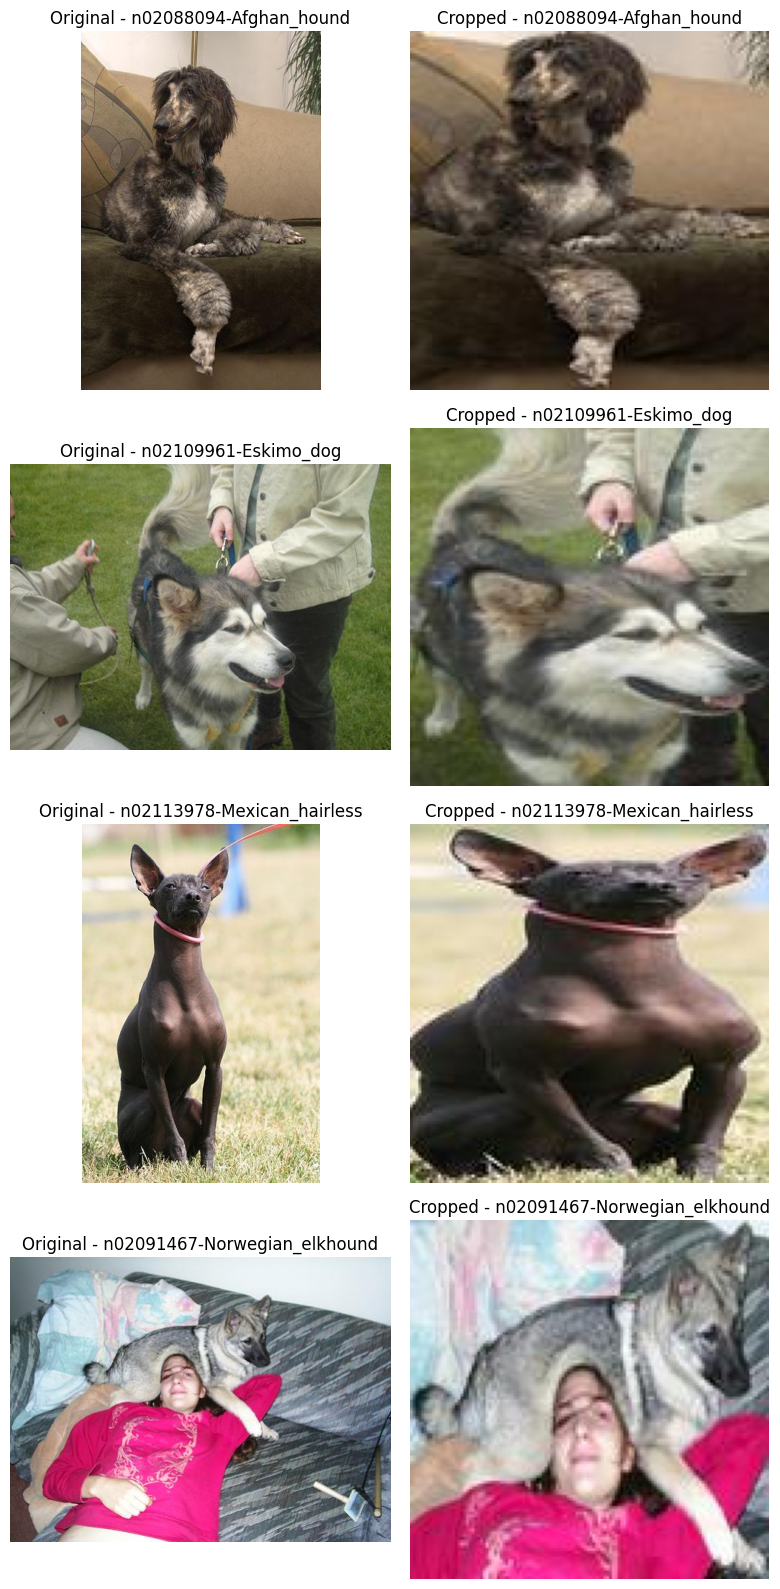

In [124]:
import random


fig, axes = plt.subplots(len(dog_classes), 2, figsize=(8, 4 * len(dog_classes)))

for idx, dog_class in enumerate(dog_classes):
    class_image_dir = os.path.join(base_image_dir, dog_class)
    class_cropped_dir = os.path.join(cropped_img_dir, dog_class)

    # Randomly select an image from the class directory
    image_files = [f for f in os.listdir(class_image_dir) if f.endswith(".jpg")]
    if image_files:
        random_image = random.choice(image_files)
        image_path = os.path.join(class_image_dir, random_image)

        # Load the original image
        original_img = Image.open(image_path)

        # Find the corresponding cropped image
        cropped_path = os.path.join(class_cropped_dir, random_image)

        if os.path.exists(cropped_path):
            # Load the cropped image
            cropped_img = Image.open(cropped_path)

            # Display the original and cropped images side by side
            axes[idx, 0].imshow(original_img)
            axes[idx, 0].set_title(f"Original - {dog_class}")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(cropped_img)
            axes[idx, 1].set_title(f"Cropped - {dog_class}")
            axes[idx, 1].axis("off")
        else:
            print(f"Cropped image not found for {random_image}")
    else:
        print(f"No images found in {dog_class} directory")

plt.tight_layout()
plt.show()


## b)


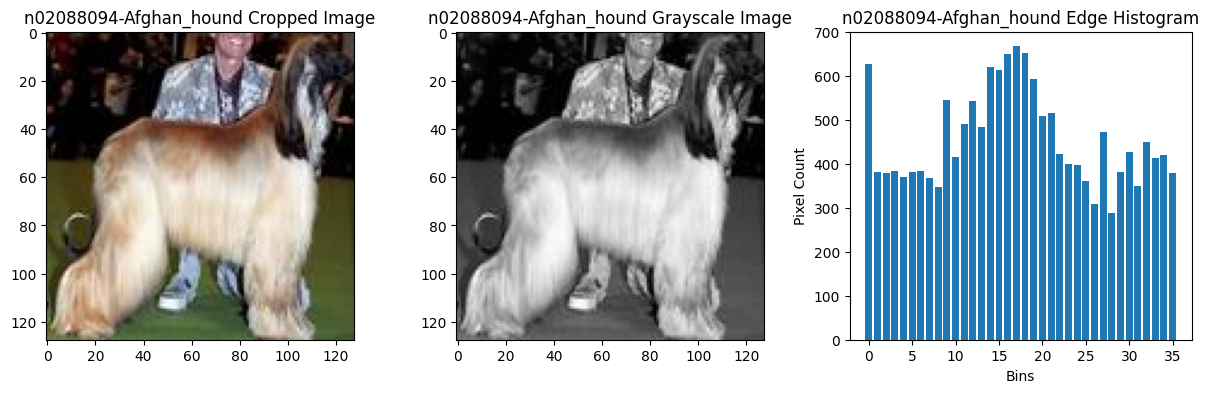

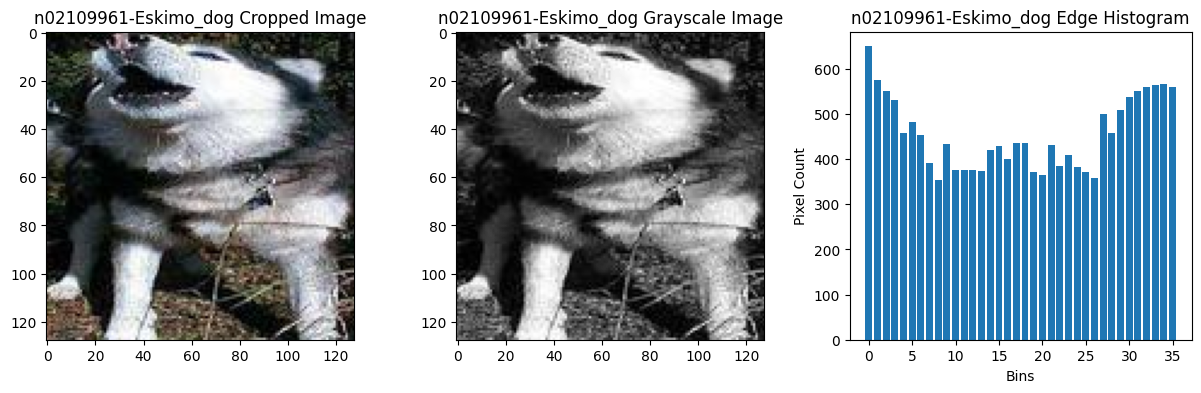

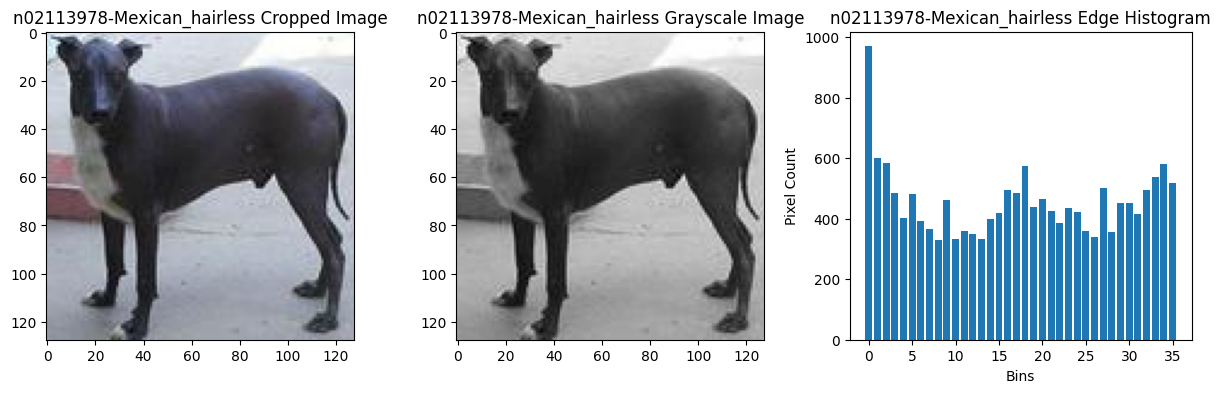

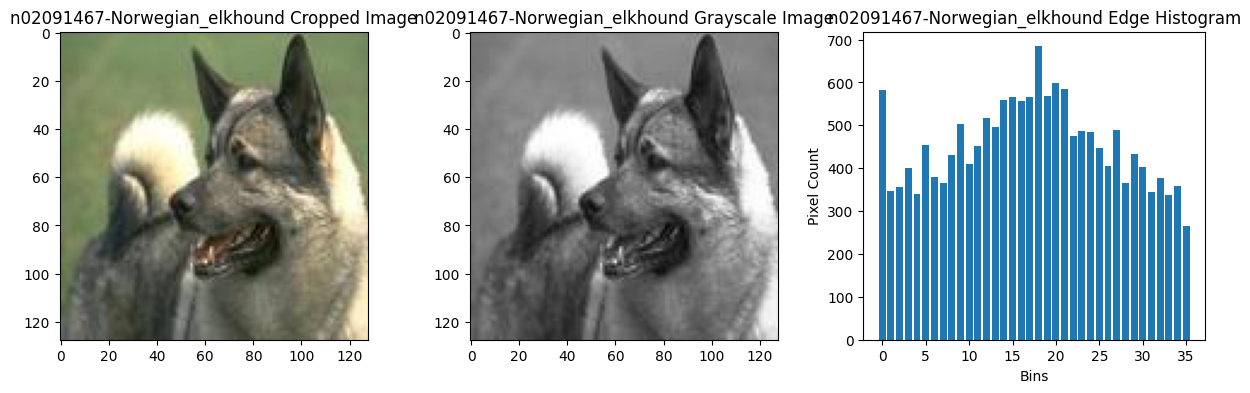

Comparing edge histograms of n02088094-Afghan_hound and n02109961-Eskimo_dog
Euclidean distance: 827.7487541518864
Manhattan distance: 4248.0
Cosine distance: 0.04405345627443302


In [125]:
def convert_to_grayscale_and_save(image_path, class_output_dir):
    image = Image.open(image_path)
    grayscale_image = image.convert("L")
    grayscale_path = os.path.join(class_output_dir, os.path.basename(image_path))
    grayscale_image.save(grayscale_path)
    return np.array(grayscale_image)


def calculate_edge_angle(grayscale_image):
    sobel_h = filters.sobel_h(grayscale_image)
    sobel_v = filters.sobel_v(grayscale_image)
    angle_sobel = np.mod(np.arctan2(sobel_v, sobel_h), np.pi)
    return angle_sobel


def compute_edge_histogram(angle_sobel):
    hist, hist_centers = exposure.histogram(angle_sobel, nbins=36)
    return hist, hist_centers


def plot_histogram(cropped_image, grayscale_image, hist, class_name):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cropped_image)
    plt.title(f"{class_name} Cropped Image")

    plt.subplot(1, 3, 2)
    plt.imshow(grayscale_image, cmap="gray")
    plt.title(f"{class_name} Grayscale Image")

    plt.subplot(1, 3, 3)
    plt.bar(range(len(hist)), hist)
    plt.xlabel("Bins")
    plt.ylabel("Pixel Count")
    plt.title(f"{class_name} Edge Histogram")
    plt.show()


def compare_histograms(hist1, hist2):
    hist1 = hist1.reshape(1, -1)
    hist2 = hist2.reshape(1, -1)
    euclidean_dist = pairwise_distances(hist1, hist2, metric="euclidean")[0][0]
    manhattan_dist = pairwise_distances(hist1, hist2, metric="manhattan")[0][0]
    cosine_dist = pairwise_distances(hist1, hist2, metric="cosine")[0][0]

    return euclidean_dist, manhattan_dist, cosine_dist


histograms = []
class_names = []

for dog_class in dog_classes:
    class_image_dir = os.path.join(cropped_img_dir, dog_class)
    class_output_dir = os.path.join(gray_output_dir, dog_class)
    Path(class_output_dir).mkdir(parents=True, exist_ok=True)

    img_files = os.listdir(class_image_dir)
    if img_files:
        img_file = img_files[0]
        image_path = os.path.join(class_image_dir, img_file)

        cropped_image = Image.open(image_path)
        grayscale_image = convert_to_grayscale_and_save(image_path, class_output_dir)

        angle_sobel = calculate_edge_angle(grayscale_image)

        hist, hist_centers = compute_edge_histogram(angle_sobel)

        histograms.append(hist)
        class_names.append(dog_class)

        plot_histogram(cropped_image, grayscale_image, hist, dog_class)
    else:
        print(f"No cropped images found for {dog_class}")

if len(histograms) >= 2:
    hist1, hist2 = histograms[0], histograms[1]
    class1, class2 = class_names[0], class_names[1]

    print(f"Comparing edge histograms of {class1} and {class2}")

    euclidean_dist, manhattan_dist, cosine_dist = compare_histograms(hist1, hist2)

    print(f"Euclidean distance: {euclidean_dist}")
    print(f"Manhattan distance: {manhattan_dist}")
    print(f"Cosine distance: {cosine_dist}")
else:
    print("Not enough histograms to compare")


## c)


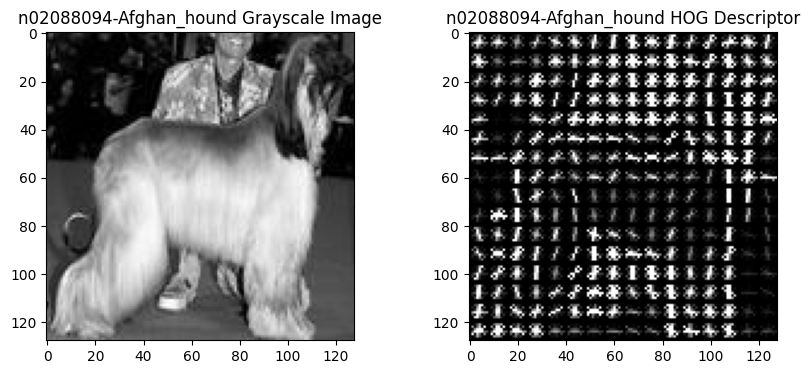

In [126]:
def compute_and_visualize_hog(grayscale_image, class_name):
    hog_features, hog_image = hog(
        grayscale_image,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        block_norm="L2-Hys",
    )

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(grayscale_image, cmap="gray")
    plt.title(f"{class_name} Grayscale Image")

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image_rescaled, cmap="gray")
    plt.title(f"{class_name} HOG Descriptor")
    plt.show()


chosen_class = "n02088094-Afghan_hound"
class_image_dir = os.path.join(gray_output_dir, chosen_class)

img_file = os.listdir(class_image_dir)[0]
grayscale_image_path = os.path.join(class_image_dir, img_file)


grayscale_image = io.imread(grayscale_image_path)


compute_and_visualize_hog(grayscale_image, chosen_class)


## d)


In [127]:
# all_histograms = []
# all_labels = []
# total_images = 0

# for dog_class in dog_classes:
#     class_image_dir = os.path.join(gray_output_dir, dog_class)
#     class_histogram_dir = os.path.join(edge_histograms_dir, dog_class)
#     os.makedirs(class_histogram_dir, exist_ok=True)

#     class_count = 0
#     for img_file in os.listdir(class_image_dir):
#         if img_file.endswith(".jpg"):
#             image_path = os.path.join(class_image_dir, img_file)

#             grayscale_image = np.array(Image.open(image_path))

#             angle_sobel = calculate_edge_angle(grayscale_image)

#             hist, _ = compute_edge_histogram(angle_sobel)

#             histogram_file = os.path.splitext(img_file)[0] + "_edge_histogram.npy"
#             histogram_path = os.path.join(class_histogram_dir, histogram_file)
#             np.save(histogram_path, hist)

#             class_count += 1
#             total_images += 1

#     print(f"Converted {class_count} images for class {dog_class}")

# print(f"\nTotal images converted: {total_images}")


# Initialize counters and storage
all_histograms = []
all_labels = []
total_images = 0
class_counts = {}

# Process each dog class
for dog_class in dog_classes:
    # Setup directories for this class
    class_image_dir = os.path.join(cropped_img_dir, dog_class)
    class_gray_dir = os.path.join(gray_output_dir, dog_class)
    class_histogram_dir = os.path.join(edge_histograms_dir, dog_class)

    # Create output directories if they don't exist
    Path(class_gray_dir).mkdir(parents=True, exist_ok=True)
    Path(class_histogram_dir).mkdir(parents=True, exist_ok=True)

    # Initialize class counter
    class_count = 0

    # Process all images in the class directory
    for img_file in os.listdir(class_image_dir):
        if img_file.endswith((".jpg", ".jpeg", ".png")):
            try:
                # Setup paths
                image_path = os.path.join(class_image_dir, img_file)

                # Convert to grayscale
                image = Image.open(image_path)
                grayscale_image = image.convert("L")

                # Save grayscale image
                gray_path = os.path.join(class_gray_dir, img_file)
                grayscale_image.save(gray_path)

                # Convert to numpy array for processing
                grayscale_array = np.array(grayscale_image)

                # Calculate edge angles
                angle_sobel = calculate_edge_angle(grayscale_array)

                # Compute histogram
                hist, _ = compute_edge_histogram(angle_sobel)

                # Save histogram
                histogram_file = os.path.splitext(img_file)[0] + "_edge_histogram.npy"
                histogram_path = os.path.join(class_histogram_dir, histogram_file)
                np.save(histogram_path, hist)

                # Add to lists for later use
                all_histograms.append(hist)
                all_labels.append(dog_class)

                class_count += 1
                total_images += 1

            except Exception as e:
                print(f"Error processing {img_file} in class {dog_class}: {str(e)}")
                continue

    class_counts[dog_class] = class_count
    print(f"Processed {class_count} images for class {dog_class}")

print("\nProcessing Summary:")
print("-" * 50)
for dog_class, count in class_counts.items():
    print(f"{dog_class}: {count} images")
print(f"\nTotal images processed: {total_images}")

all_histograms = np.array(all_histograms)
all_labels = np.array(all_labels)


Processed 239 images for class n02088094-Afghan_hound
Processed 150 images for class n02109961-Eskimo_dog
Processed 155 images for class n02113978-Mexican_hairless
Processed 196 images for class n02091467-Norwegian_elkhound

Processing Summary:
--------------------------------------------------
n02088094-Afghan_hound: 239 images
n02109961-Eskimo_dog: 150 images
n02113978-Mexican_hairless: 155 images
n02091467-Norwegian_elkhound: 196 images

Total images processed: 740


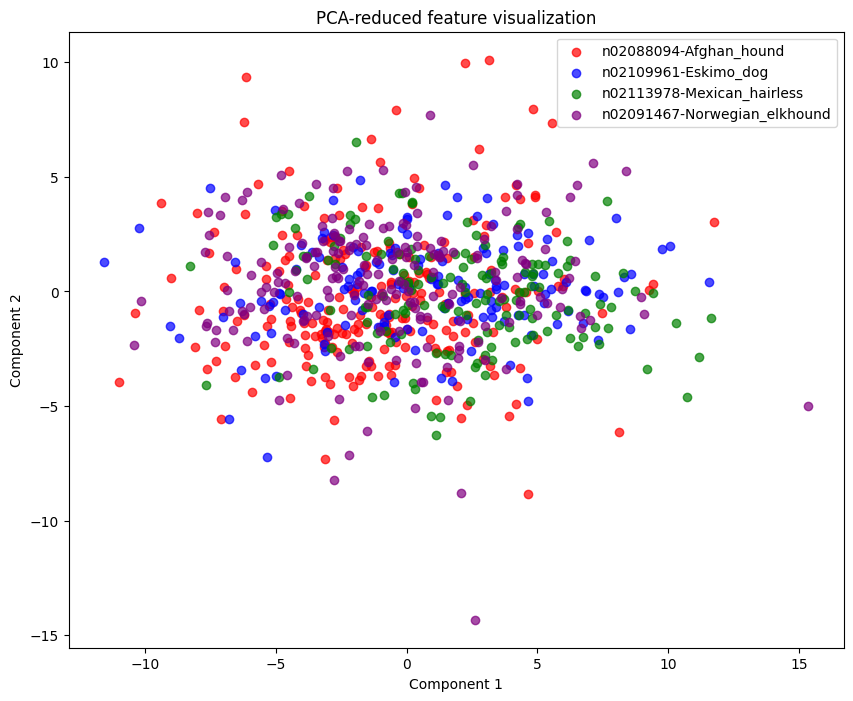

In [128]:
X = np.array(all_histograms)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
colors = ["red", "blue", "green", "purple"]
for i, dog_class in enumerate(dog_classes):
    mask = np.array(all_labels) == dog_class
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors[i], label=dog_class, alpha=0.7)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA-reduced feature visualization")
plt.legend()
plt.show()

Based on the 2D PCA visualization of the 4 dog breed classes, we can observe
that:

- The data points show significant overlap between most classes
- The Afghan_hound (red), Eskimo_dog (blue), and Norwegian_elkhound (purple)
  classes have substantial overlap in the feature space
- The Mexican_hairless class (green) shows some separation from the other
  classes, particularly in having more points clustered in the positive
  Component 1 region
- There is still some overlap between Mexican_hairless and the other classes


# 3.)


In [129]:
with open("train.json", "r") as f:
    data = [json.loads(line) for line in f]


df = pd.DataFrame(data)


In [130]:
selected_classes = ["anger", "joy", "love", "sadness"]
df["class"] = df[selected_classes].idxmax(axis=1)
df_filtered = df[df[selected_classes].sum(axis=1) == 1]


texts = df_filtered["Tweet"].values
labels = df_filtered["class"].values


count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()


count_features = count_vectorizer.fit_transform(texts)
tfidf_features = tfidf_vectorizer.fit_transform(texts)


count_dim = count_features.shape[1]
tfidf_dim = tfidf_features.shape[1]

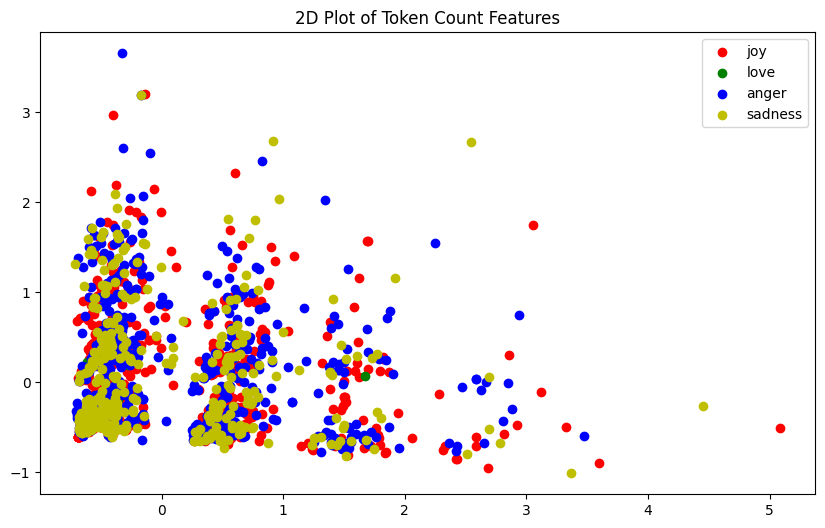

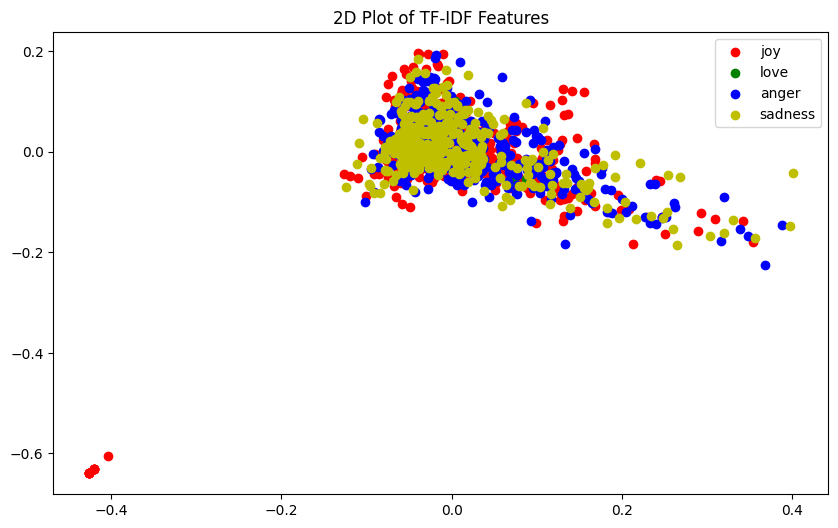

Dimensionality of token count features: 6528
Dimensionality of TF-IDF features: 6528


In [131]:
pca = PCA(n_components=2)
count_reduced = pca.fit_transform(count_features.toarray())
tfidf_reduced = pca.fit_transform(tfidf_features.toarray())


def plot_reduced_features(reduced_features, labels, title):
    plt.figure(figsize=(10, 6))
    unique_labels = list(set(labels))
    colors = ["r", "g", "b", "y"]
    for i, label in enumerate(unique_labels):
        indices = [j for j, label_j in enumerate(labels) if label_j == label]
        plt.scatter(
            reduced_features[indices, 0],
            reduced_features[indices, 1],
            c=colors[i],
            label=label,
        )
    plt.title(title)
    plt.legend()
    plt.show()


plot_reduced_features(count_reduced, labels, "2D Plot of Token Count Features")


plot_reduced_features(tfidf_reduced, labels, "2D Plot of TF-IDF Features")


print(f"Dimensionality of token count features: {count_dim}")
print(f"Dimensionality of TF-IDF features: {tfidf_dim}")

For both token count and TF-IDF features, no classes are clearly separable as
there is significant overlap among the classes in the 2D PCA projection.
